# **Dataset 4 - Coronavirus tweets NLP - Text Classification**

**Description**
The "Coronavirus Tweets NLP - Text Classification" dataset contains thousands of tweets during the COVID-19 pandemic. Each tweet is annotated with one of five sentiment labels: extremely positive, positive, neutral, negative, or extremely negative. The dataset includes the text of each tweet, the user's location, and the date it was posted, enabling detailed analysis of public sentiment and trends during the early phase of the pandemic.

**Source**
https://www.kaggle.com/datasets/datatattle/covid-19-nlp-text-classification

**Machine Learning Task**
Multi-class Classification

**Motivation**
Twitter posts provide a great source of text data, as they reflect opinions from users worldwide. This dataset focuses on tweets about the coronoavirus during a time of reduced social interaction. Analyzing sentiments during this period offers insights into how the pandemic affected public opinions, especially regarding negative sentiments.

**Objective**
Develop a model to classify the sentiment expressed in tweets, aiding in sentiment analysis, trend detection, and public opinion monitoring during health crises.

The two machine learning models that will be used in this classification are Logistic Regression and Random Forest Classifier.

In [49]:
# # optional code cell when using Google Colab with Google Drive
# # mount Google Drive in Google Colab
# from google.colab import drive
# drive.mount('/content/drive')

# # change directory using the magic command %cd
# ### replace [MY PATH] below with your own path in Google Drive ###
# %cd /content/drive/My\ Drive/Fall 2024/ECE443/Term Project/Coronavirus Tweets NLP - Text Classification

In [50]:
# Imports
import numpy as np
import pandas as pd
from scipy import stats as sps
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Latex
from wordcloud import WordCloud
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter
import re
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from numpy import count_nonzero
import time

# Brief Exploration of the Dataset

In this section, Exploratory Data Analysis (EDA) is performed on the dataset to gain insight into the context, dimensionality, and common patterns in the data that will be handled and noted for pre-processing and future work.

In [51]:
# Read the train data CSV file into a dataframe
train_df = pd.read_csv('Corona_NLP_train.csv', encoding='Latin-1')

# Read the test data CSV file into a dataframe - NOTE: test set shall only be used for evaluations of models, but will have same processing applied to it (NO DATA LEAKAGE)
test_df = pd.read_csv('Corona_NLP_test.csv', encoding='Latin-1')

# Display all columns
print("Columns:")
display(train_df.columns)

# Display dtypes
print("\nData Types:")
display(train_df.dtypes)

# Display the first 10 rows of the train dataset
print("\nFirst 10 rows:")
train_df.head()

Columns:


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


Data Types:


UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
dtype: object


First 10 rows:


,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


There are six columns in the dataset: UserName (identifier, name), ScreenName (identifier, screen name), Location (where the Tweet originated from), TweetAt (the date the tweet was posted), OriginalTweet (the raw twitter text), and Sentiment (the label). There are *3 raw features*: Location, TweetAt, and OriginalTweet. There are *3 categorical variables*: Location, TweetAt, and Sentiment. There is currently *1 text data variable*: OriginalTweet. The output target variable is Sentiment.

The UserName and ScreenName columns are simply identifiers and are not considered as part of the feature or target variables.

In [52]:
# Get the number of samples
num_samples = len(train_df)
print(f"Number of samples: {num_samples}")

# Get the fraction of missing values
missing_values = train_df.isnull().sum() / num_samples
print(f"\nFraction of missing values: \n{missing_values}")

# Get the number of unique values in each column
unique_values = train_df.nunique()
print(f"\nNumber of unique values: \n{unique_values}")

# Get the number of (if any) duplicate samples
duplicate_samples = train_df.duplicated().sum()
print(f"\nNumber of duplicate samples: {duplicate_samples}")

Number of samples: 41157

Fraction of missing values: 
UserName         0.000000
ScreenName       0.000000
Location         0.208713
TweetAt          0.000000
OriginalTweet    0.000000
Sentiment        0.000000
dtype: float64

Number of unique values: 
UserName         41157
ScreenName       41157
Location         12220
TweetAt             30
OriginalTweet    41157
Sentiment            5
dtype: int64

Number of duplicate samples: 0


There are 41,157 data samples in the training dataset. Only the Location column has missing values (roughly 20.9% of the column has missing values). Based on the analysis of the number of unique values in each column, the UserName, ScreenName, and OriginalTweet columns have distinct values. The Location, TweetAt, and Sentiment columns have non-unique values.

In [53]:
# # Generate a word cloud to analyze the frequency of words that appear in the Tweets
# tweet_text = train_df['OriginalTweet'].str.cat(sep=' ')
# wordcloud = WordCloud(
#     background_color='white'
# ).generate(tweet_text)

# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")
# plt.show()

As shown in the WordCloud, some of the most common words used in the Tweets include irrelevant words such as "https", "amp", "t", "co", etc. which are associated with links and other text that has no true bearing on the sentiment or expressions behind the text. Nonetheless, as expected, some more useful common words do surface, such as "COVID" (as expected), "supermarket", "price", "food", etc. which may influence the sentiment of the text.

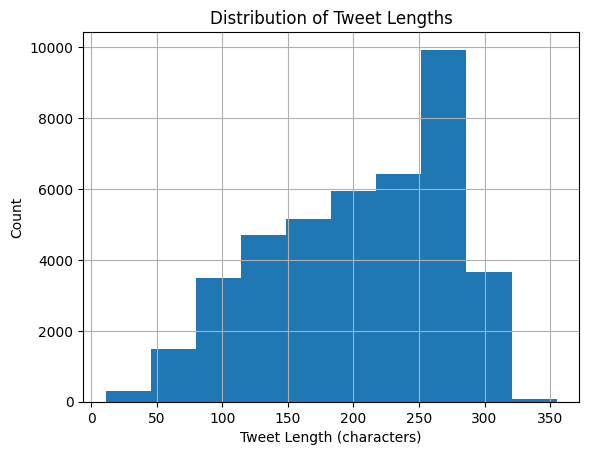

In [54]:
# Create histogram of the length of each tweet (number of characters)
train_df['OriginalTweet'].str.len().hist()
plt.xlabel('Tweet Length (characters)')
plt.ylabel('Count')
plt.title('Distribution of Tweet Lengths')
plt.show()

As shown, the raw tweet lengths (in terms of number of characters in the text) are left-skewed, with the mode tweet length around 250 to 275 characters. Very few tweets are beyond 325 characters in length.

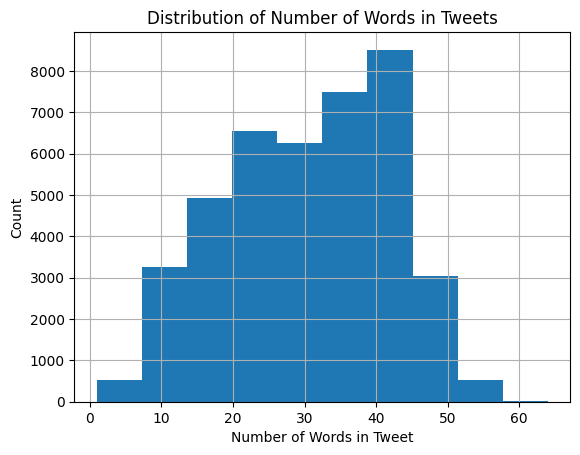

In [55]:
# Create a histogram of the number of words in each tweet
train_df['OriginalTweet'].str.split().map(lambda x : len(x)).hist()
plt.xlabel('Number of Words in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Number of Words in Tweets')
plt.show()

As shown, the distribution of the number of words in a Tweet is roughly uniformly distributed, with the mean number of words in a Tweet hovering around 30 to 35 words.

Maximum length of any word in any Tweet: 279


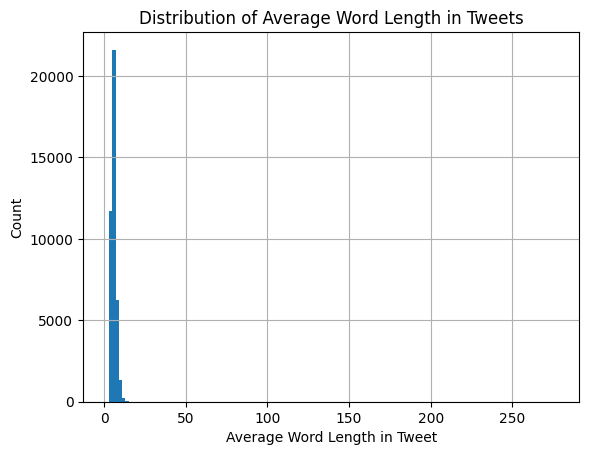

In [56]:
# Create a histogram of the average word length in each tweet
max_word_length = int(train_df['OriginalTweet'].str.split().map(lambda x : np.mean([len(word) for word in x])).max())
print(f"Maximum length of any word in any Tweet: {max_word_length}")

train_df['OriginalTweet'].str.split().map(lambda x : np.mean([len(word) for word in x])).hist(bins=[i for i in range(1, max_word_length, 2)])
plt.xlabel('Average Word Length in Tweet')
plt.ylabel('Count')
plt.title('Distribution of Average Word Length in Tweets')
plt.show()

As shown, the average length of the words in a Tweet is mostly from length 1 to 25. However, there are outliers, since the maximum average word length in a tweet is 279.

However, this does not directly imply that the Tweets only use very short words. For instance, the Tweets may contain stopwords, which are words most commonly used in the language ("the", "a", etc.). This is most likely causing the skew displayed in the distribution of average word lengths, so it is important to analyze how many and the types of stopwords there are in the Tweet text to gain more insight into the data.

The nltk library provides a corpus of stopwords from various languages; given the data exploration, however, the texts are in English, and so the English stopwords will be extracted from the corpus in the following exercise.

In [57]:
# Download nltk corpus and extract english stop words
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


As shown, the extracted english stopwords from the nltk corpus are very common words in the English language, which are not as relevant towards the sentiment of the Tweets.

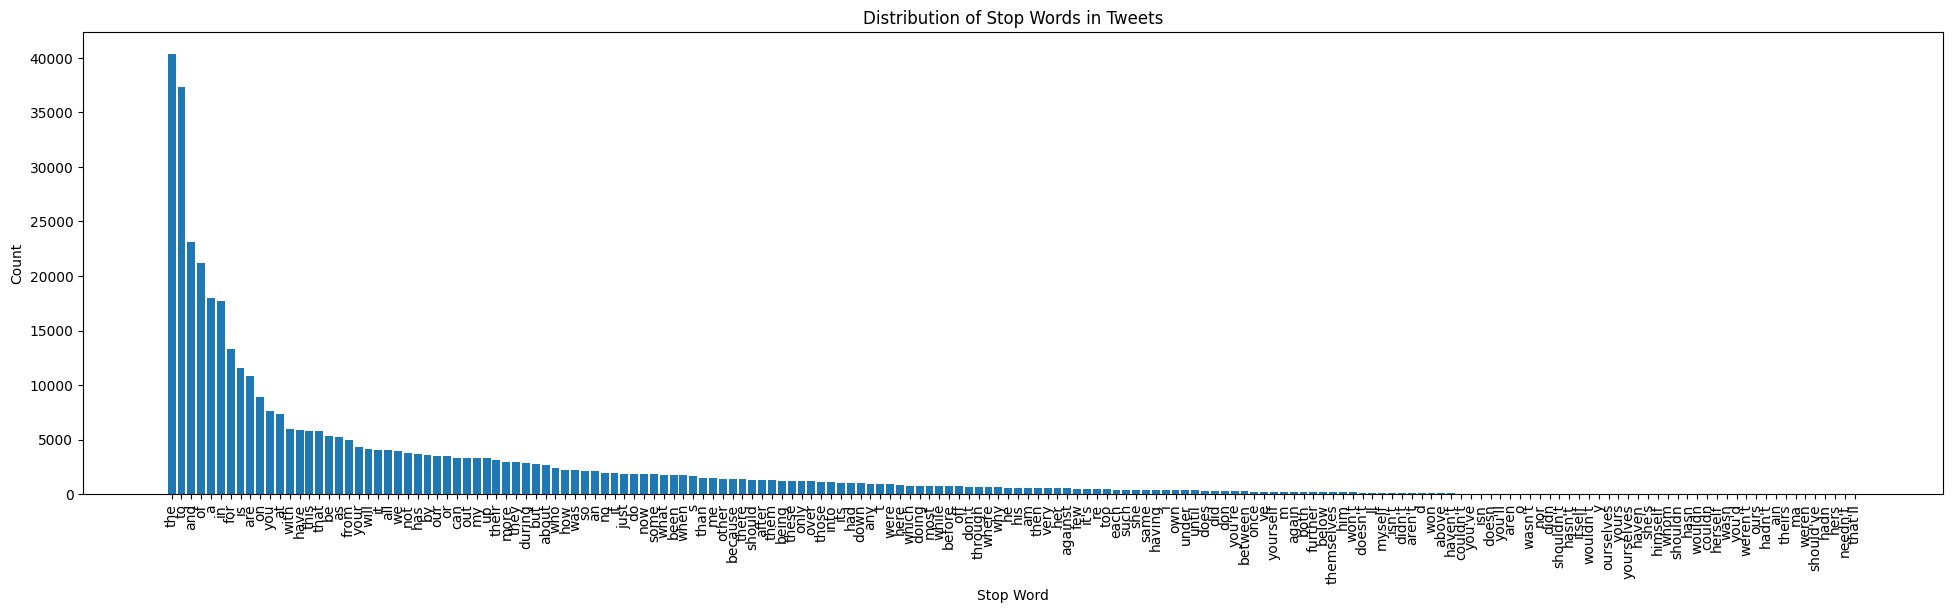

In [58]:
# Create corpus of all words from the Tweets
corpus = [word for tweet in train_df['OriginalTweet'].str.split().values.tolist() for word in tweet]

# Count how many times each stop word appears in the Tweets (using the corpus created above)
count_stop_words = defaultdict(int)
for word in corpus:
  if word in stop_words:
    count_stop_words[word] += 1

# Sort in decreasing frequency of stop words
count_stop_words = dict(sorted(count_stop_words.items(), key=lambda freq : freq[1], reverse=True))

# Plot the frequency of stop words in the Tweets
plt.figure(figsize=(24,6))
plt.bar(count_stop_words.keys(), count_stop_words.values())
plt.xlabel('Stop Word')
plt.ylabel('Count')
plt.title('Distribution of Stop Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Thus, it is immediately evident that the Tweets collectively contain thousands of stop words, with the most common ones including "the", "to", "and", "of", "a", "in", "for", "is", "are", "on", "you", "at", etc.

The implications are that in the pre-processing of the data, in addition to words unrelated to sentiment such as "https", stopwords will also need to be filtered out to reduce the dimensionality of the numerical vectors representing the text data and reduce noise in the data when predicting sentiment. This is explored in greater detail in a future section.

Although the WordCloud provided a visualization of the top words in the Tweets, the actual count of the top 20 most common words in the Tweets can also be analyzed in the following exercise.

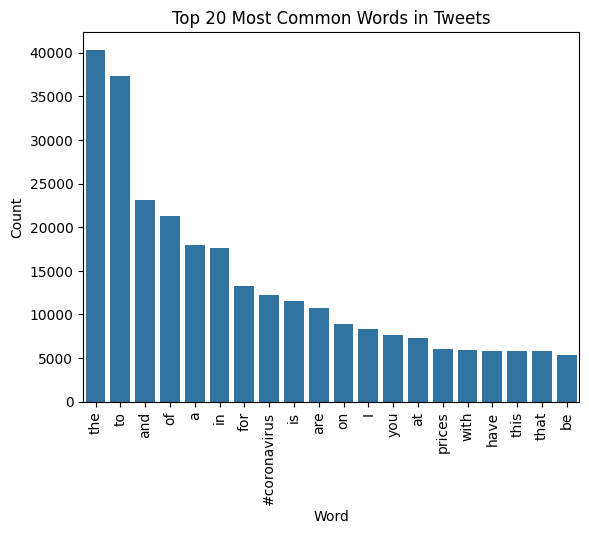

In [59]:
# Get the top 20 most common words in the Tweets
counter = Counter(corpus)
top_20_most_common_words = counter.most_common(20)

# Plot the top 20 most common words in the Tweets and their counts
word_list, count_list = zip(*top_20_most_common_words)
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Top 20 Most Common Words in Tweets')
plt.xticks(rotation=90)
plt.show()

Again, observe that so many of the most common words in the tweets are part of the stop words (compare with the distribution of stop words in the previous exercise). Stopwords like "the", "to", "and", etc. should be filtered from the Tweets' texts during the pre-processing stage.

Another exercise in exploring the text data involves exploring Ngrams, which are contiguous sequences of n words. For instance, N = 2 for "I am", N = 3 for "Who are you", etc. Exploring the most frequent Ngrams in the text data can provide insight into not just the words in the Tweets, but also their context windows. For the following exercise, Ngrams is implemented with the nltk.util module.

The Tweet text vocabulary is represented through the Countervectorizer method in sklearn.feature_engineering.text, which helps tokenize/vectorize and represent the corpus.

In [60]:
def get_top_Ngrams(corpus, n=1, top=10):
  """
  Retrieves the top Ngrams from the corpus.

  :param n: the top Ngrams to retrieve
  :param top: the number of top Ngrams to retrieve
  :return: a list of the top Ngrams based on decreasing frequency
  """
  vectorized = CountVectorizer(ngram_range=(n,n)).fit(corpus) # initialize a CountVectorizer that extracts n-grams of size n (e.g., for n=2, ["i like my phone"] = ["i like", "like my", "my phone"]) and fits the corpus to build vocab of n-grams
  bag_of_words = vectorized.transform(corpus) # convert corpus into sparse matrix bag of words, rows are documents and columns are counts of n-grams
  sum_of_words = bag_of_words.sum(axis=0) # collapse sparse matrix into one row, each column is total number of the n-gram for that corpus
  frequency_of_words = [(word, sum_of_words[0,index]) for word, index in vectorized.vocabulary_.items()] # the vocabulary_ is a dict mapping every n-gram to the sparse matrix index; this creates a list of tuples, each tuple is an n-gram with total count of it
  frequency_of_words = sorted(frequency_of_words, key=lambda x : x[1], reverse=True) # sort the n-grams by frequency
  return frequency_of_words[:top] # return the top n-grams

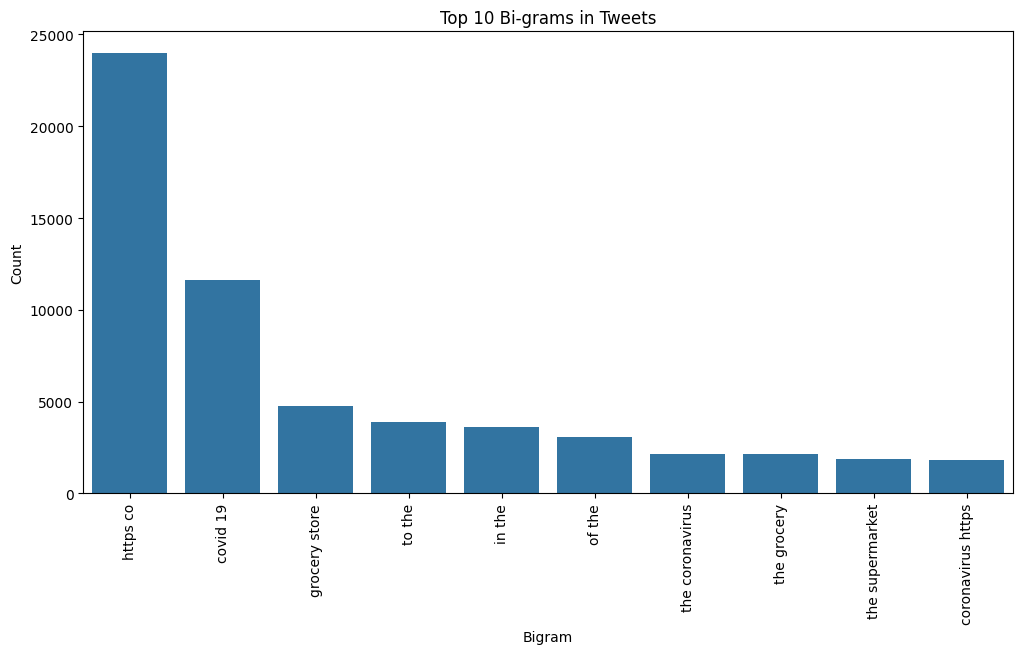

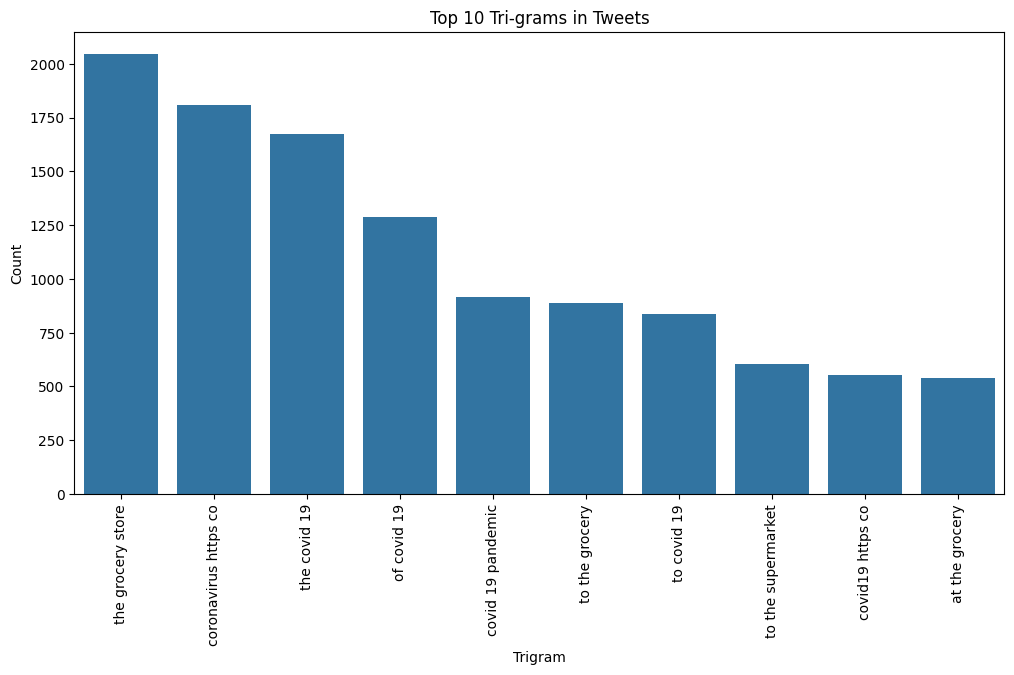

In [61]:
# Get the top 10 bi-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=2, top=10)

# Plot the top 10 bi-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Bigram')
plt.ylabel('Count')
plt.title('Top 10 Bi-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

# Get the top 10 tri-grams from the Tweets
top_10_bigrams = get_top_Ngrams(train_df['OriginalTweet'], n=3, top=10)

# Plot the top 10 tri-grams from the Tweets
word_list, count_list = zip(*top_10_bigrams)
plt.figure(figsize=(12,6))
sns.barplot(x=word_list, y=count_list)
plt.xlabel('Trigram')
plt.ylabel('Count')
plt.title('Top 10 Tri-grams in Tweets')
plt.xticks(rotation=90)
plt.show()

Based on the top 10 bi-grams and tri-grams from the Tweet text data, it seems like the "grocery" store and "supermarket" and "covid 19" are featured the most. Synonyms such as "grocery store" and "supermarket" can be combined into singular tokens during data cleaning and pre-processing. Also, it is again obvious that irrelevant words such as "https" and "co" appear in these Ngrams and will need to be filtered as well.

As a final exercise, the distribution of target classes (the sentiment labels) are explored.

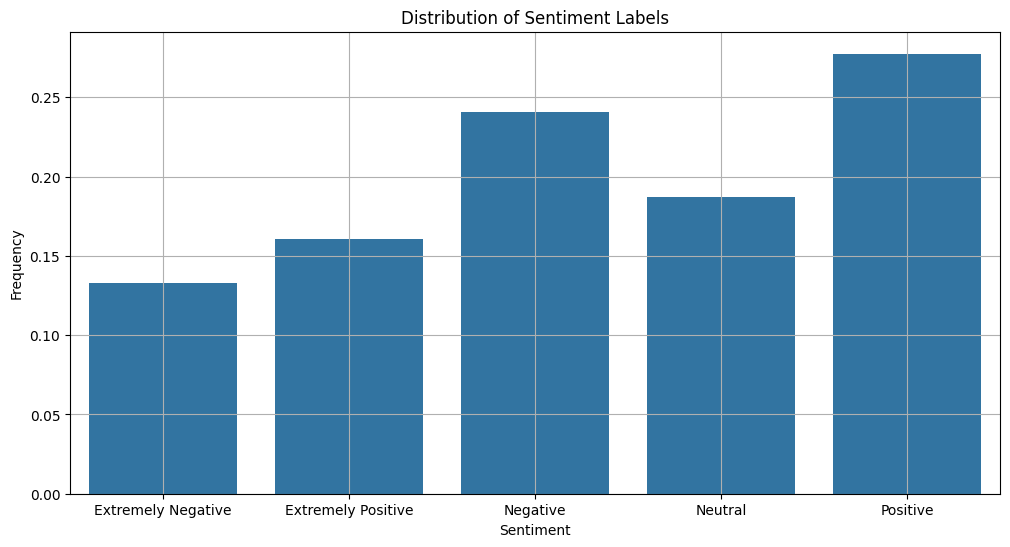

Sentiment
Extremely Negative    0.133173
Extremely Positive    0.160945
Negative              0.240955
Neutral               0.187404
Positive              0.277523
Name: Sentiment, dtype: float64

In [62]:
# Plot the frequency/empirical prior probability for each sentiment label class
sentiment_counts = train_df['Sentiment'].groupby(train_df['Sentiment']).count()
sentiment_frequencies = sentiment_counts / sentiment_counts.sum()

plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_frequencies.index, y=sentiment_frequencies.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid()
plt.show()

sentiment_frequencies

The distribution of sentiment labels is not really uniform. The "Positive" sentiment class is most frequent with an empirical prior probability of 0.277523, followed by the "Negative" sentiment class with an empirical prior probability of 0.240955, followed by the "Neutral" sentiment class with an empirical prior probability of 0.187404, follwed by the "Extremely Positive" sentiment class with an empirical prior probability of 0.160945, followed by the "Extremely Negative" sentiment class with the lowest empirical prior probability of 0.133173.

# Pre-Processing of the Dataset

In this section, the dataset is preprocessed, which is guided by the previous section of exploration of the dataset as well as forthcoming plans for the dataset.

First, there is no need for the Location or TweetAt columns, as the main focus is sentiment analysis on the text itself. This can also help remove bias based on location or time of Tweet.

Moreover, observe that 'Extremely Negative' labels will be treated as 'Negative' and 'Extremely Positive' labels will be treated as 'Positive'. For this task and our group's purpose, the *direction* of the sentiment of a text is of more interest than reaching deep inside the semantic of itself to determine how "extreme" the semantic of the text is. This also helps reduce the class size and address the large imbalance between positive and negative sentiments as was explored in EDA. This is demonstrated in the exercise below.

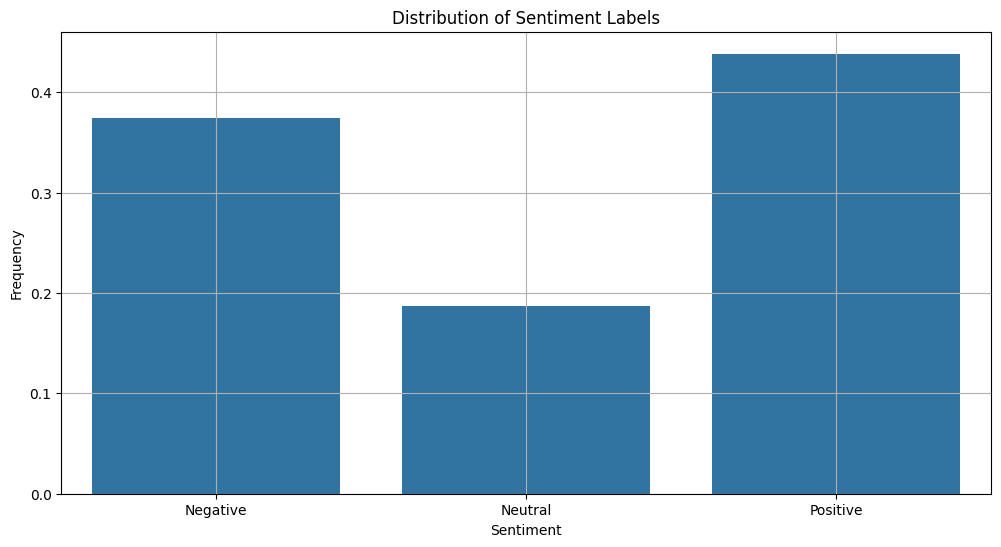

Frequencies of sentiment class distributions:


Sentiment
Negative    0.374128
Neutral     0.187404
Positive    0.438467
Name: Sentiment, dtype: float64

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,My food stock is not the only one which is emp...,Positive
4,3803,48755,"Me, ready to go at supermarket during the #COV...",Negative


In [63]:
# Drop the Location and TweetAt columns
train_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

# Do the same on the test set
test_df.drop(['Location', 'TweetAt'], axis=1, inplace=True)

# Converge extremities in training data
train_df['Sentiment'] = train_df['Sentiment'].replace({
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive'
})

# Converge extremities in test data
test_df['Sentiment'] = test_df['Sentiment'].replace({
    'Extremely Negative': 'Negative',
    'Extremely Positive': 'Positive'
})

sentiment_counts = train_df['Sentiment'].groupby(train_df['Sentiment']).count()
sentiment_frequencies = sentiment_counts / sentiment_counts.sum()

plt.figure(figsize=(12,6))
sns.barplot(x=sentiment_frequencies.index, y=sentiment_frequencies.values)
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels')
plt.grid()
plt.show()

print("Frequencies of sentiment class distributions:")
display(sentiment_frequencies)

display(train_df.head())

Observe that in the above plot, simplifying down to three classes helps address the large class imbalance between negative and positive sentiments. However, there is still a large class imbalance with the netural sentiment labels. This suggests that in future sections, when selecting models and tuning their parameters, F1 score may be of more interest (harmonic mean between precision and recall) compared to accuracy. Also, when evaluating the models, attention will have to be focused on the metrics for neutral sentiment classification due to this class imbalance.

The first step of pre-processing the data involves directly dropping the Location and TweetAt columns in the dataframe. This is because the ultimate objective is to predict the sentiment class based on the Tweet text, which does not depend on the location the Tweet originated from nor the date the Tweet was posted.

Moreover, observe that there is no need for replacing invalid entries with plausible values, since during EDA, it was observed that only the Location column had invalid entries (such as NaN), which is being dropped from the dataframe.

Now, the Sentiment output variable has to be processed. Specifically, it is a categorical variable with 3 categories/classes ("Negative", "Neutral", and "Positive"). In fact, it is an *ordinal categorical variable* since there is a natural order/ranking of the classes (with no exact distance between): "Positive" > "Neutral" > "Negative". Therefore, the following exercise encodes the Sentiment categorical variable with *label encoding* to capture the natural ranking of the categories while transforming them into numerical values that can be processed in machine learning models.

In [64]:
# Define label encoding map for the 5 sentiment classes
sentiment_mapping = {
    "Positive": 2,
    "Neutral": 1,
    "Negative": 0,
}

# Encode the Sentiment column with label encoding
train_df['Sentiment'] = train_df['Sentiment'].map(sentiment_mapping)

# Do the same for test set
test_df['Sentiment'] = test_df['Sentiment'].map(sentiment_mapping)

train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1
1,3800,48752,advice Talk to your neighbours family to excha...,2
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2
3,3802,48754,My food stock is not the only one which is emp...,2
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0


Now the Sentiment variable is label encoded. However, the original tweet data is still text data and is not currently fit to be fed into a machine learning model for processing, so it has to be encoded as well. This will be performed in the next section ("Feature Extraction/Feature Learning from the Dataset").

The other pending issue is that during EDA, it was discovered that the Tweet texts contained a lot of common words in the english language (stopwords) as well as irrelevant words such as non-alphanumeric data, URLs, punctuation, etc. The next exercise pre-processes and filters out such characters from the OriginalTweet text data.

In [65]:
def clean_text(text):
  """
  Removes any non-alphanumeric data, URLs, punctuation, and stop words (assuming english language) from the text and replaces with space.

  :param text: the text data to clean
  :return: the cleaned text data
  """
  # remove any URLs from the text data
  text = re.sub(r'http\S+', ' ', text)
  
  # remove tags
  text = re.sub(r'@\w*', ' ', text)
  
  # remove hashtags
  text = re.sub(r'#\w*', ' ', text)
  
  # remove apostrophes
  text = re.sub(r"'s\b", "", text)

  # remove any non-alphanumeric data from the text data
  text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
  
  # remove numbers
  text = re.sub('[\d]', ' ', text)
  
  # convert text to lowercase so it can be compared to stop words
  text = text.lower()

  # remove stop words from the text data
  text = ' '.join([word for word in text.split() if word not in stop_words])

  return text

In [66]:
# Apply the function defined above to each data sample in the training data to clean the Tweet texts
train_df['CleanedOriginalTweet'] = train_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Do the same on the test set
test_df['CleanedOriginalTweet'] = test_df['OriginalTweet'].apply(lambda x : clean_text(x))

# Display the train dataframe with the new column for the clean Original Tweet
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...


Now that the Tweet text data was "cleaned", five random samples are taken from the training dataset and displayed below, compared to the original Tweet text and the cleaned Tweet text.

In [67]:
# Print out random 5 original tweet texts and cleaned original tweet texts in the dataframe
sample_rows = train_df.sample(n=5, random_state=123)
for original_tweet_text, cleaned_original_tweet_text in zip(sample_rows['OriginalTweet'], sample_rows['CleanedOriginalTweet']):
  print(f"> Original Tweet Text: {original_tweet_text}\n")
  print(f"> Cleaned Original Tweet Text: {cleaned_original_tweet_text}\n")
  print("-" * 50)

> Original Tweet Text: Four traders have been arrested in Koboko town in Northern Uganda for increasing the prices of their commodities- a packet of salt from Shs 800 to Shs 5,000.
#coronavirus  #COVID19 #COVIDUG

> Cleaned Original Tweet Text: four traders arrested koboko town northern uganda increasing prices commodities packet salt shs shs

--------------------------------------------------
> Original Tweet Text: Definitely expecting the companies already lagging behind their peers on online shopping investment to feel the pinch during COVID-19, especially for mobile experience

> Cleaned Original Tweet Text: definitely expecting companies already lagging behind peers online shopping investment feel pinch covid especially mobile experience

--------------------------------------------------
> Original Tweet Text: The beginning of our week of confinement https://t.co/m8emJT5xPe We have, as of yet, to be in a grocery store or other public place. #coronavirus #covid19

> Cleaned Origin

As shown, after cleaning the tweet text data, there are now no URLs, non-alphanumeric data, punctuation, and stopwords in the text. This will help improve the efficiency and accuracy of the machine learning and language processing tasks that will be explored in a future section. For instance, not only is it removing noise that is most likely uncorrelated with the sentiment of the text, but it is also reducing the number of distinct words and thus eventual features once this text data is numerically transformed (see the feature learning section on vectorization).

However, the text data can be processed further. While less relevant words were cleaned from the text data, recall that in EDA, another noted issue was that similar words or synonyms appeared in the Tweets. This can be approached with lemmatization and stemming, which are text pre-processing techniques used to reduce the inflected forms of words in the text data to a singular common root word (lemma). Both help convert the cleaned text data into a more structured format for processing in the machine learning models, by removing characters from the beginning and end of each word token. The largest distinction between the two methods is that lemmatization guarantees that the processed word is a true existing normalized version/lemma of the word from the dictionary, while stemming simply removes any common suffixes from the end of the word token (see https://www.ibm.com/think/topics/stemming-lemmatization).

The following exercise first lemmatizes the cleaned Tweet text data for each data sample.

In [68]:
def lemmatize_text(text, lemmatizer):
  """
  Lemmatizes the text data.

  :param text: the text data to clean
  :param lemmatizer: the lemmatizer to use
  :return: the lemmatized text data
  """
  # Lemmatize the text
  text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
  return text

In [69]:
# Download wordnet from nltk and initialize the lemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

# Use the function above to lemmatize each cleaned text data sample
train_df['LemmatizedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Do the same for the test set
test_df['LemmatizedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : lemmatize_text(x, lemmatizer))

# Display the train dataframe with the lemmatized clean Original Tweet
train_df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mogil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,,
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...


Stemming can also be applied to the text data to further process it and ensure a robust structured form of the text data. Stemming contains different algorithms that vary widely. Nonetheless, the general idea is to remove any word suffixes by comparing each word token again a pre-defined list of common suffixes. Then, the stemmer removes such suffixes from the word token.

In the following exercise, the *Porter stemming algorithm* is used, which based on research, seems to be the most widely used stemming algorithm (see https://www.ibm.com/think/topics/stemming-lemmatization). The Porter stemmer is chosen for this exercise because it only stems English words, which is already the context behind the dataset for this project. Had the Tweets contained other languages such as German, French, Russian, etc., the Snowball stemmer would have been more appropriate (see https://www.ibm.com/topics/stemming#:~:text=First%2C%20while%20the%20Lovins%20and,%2C%20French%2C%20and%20even%20Russian.).

**Note:** for this exercise, lemmatization is the only pre-processing technique used on the text data. This was a design choice during the project since stemming may generally be faster than lemmatization (relies on fixed rules), lemmatization involves querying its dictionary and has more complex algorithms. Since stemming may result in root forms that aren't real words in the english language, lemmatization was preferred as real unseen data (Tweets) is more likely to contain actual english words (lemmas). Still, the below exercise demonstrates how stemming (specifically the Porter stemming algorithm) can be applied to the text data. Also note that it is generally not needed to perform both lemmatization and stemming, and is there is a large overlap in redundancy.

In [70]:
# def stem_text(text):
#   """
#   Stems the text data.

#   :param text: the text data to clean
#   :stemmer: the stemmer to use
#   :return: the stemmed text data
#   """
#   # Initialize the stemmer, which will use the Porter Stemming algorithm
#   stemmer = PorterStemmer()
  
#   # Stem the text
#   text = ' '.join([stemmer.stem(word) for word in text.split()])
#   return text

In [71]:
# # Use the function above to stem each cleaned text data sample - store in a new (stemmed) dataframe so the stemming is not added on top of the lemmatization for comparison
# train_df['StemmedCleanedOriginalTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# # Do the same for the test set
# test_df['StemmedCleanedOriginalTweet'] = test_df['CleanedOriginalTweet'].apply(lambda x : stem_text(x))

# # Display the train dataframe with the stemmed clean Original Tweet
# train_df.head()

Now, a quick divergence from the purposes of this Project. Soon, there will be a section on feature learning, which will cover how a TF-IDF vectorizer is used to convert the cleaned and processed text data in numerical formats that can be processed by machine learning models. The TF-IDF vectorizer used in that exercise works with raw (non-tokenized) text data and internally performs tokenization on the string. Nonetheless, the below cell demonstrates a very basic notion of what tokenization looks like, which essentially is a form of word tokenization, in which the text is broken up into individual words, which can then be processed and converted into TF-IDF form, etc. (more on this in the feature learning section). One interesting note in the realm of machine learning and natural language processing (NLP), however, is what kind of tokenization is beneficial. For instance, character tokenization may be useful for a language with clear or granular word boundaries, but may make it more difficult to classify text based on solely characters. Word tokenization may be more suited for languages with clear word boundaries (e.g., the english language), and may possibly increase the feature space (compare the distinct number of words in the language compared to characters) while also making it more suited for classifying the meaning of text (see https://www.datacamp.com/blog/what-is-tokenization). This is just a side note, so feel free to ignore this tokenization demonstration.

In [72]:
def tokenize(text):
  tokens = re.findall(r'\b\w+\b', text)
  return tokens

train_df['TokenizedTweet'] = train_df['CleanedOriginalTweet'].apply(lambda x : tokenize(x))
train_df.head()

,UserName,ScreenName,OriginalTweet,Sentiment,CleanedOriginalTweet,LemmatizedCleanedOriginalTweet,TokenizedTweet
0,3799,48751,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,,,[]
1,3800,48752,advice Talk to your neighbours family to excha...,2,advice talk neighbours family exchange phone n...,advice talk neighbour family exchange phone nu...,"[advice, talk, neighbours, family, exchange, p..."
2,3801,48753,Coronavirus Australia: Woolworths to give elde...,2,coronavirus australia woolworths give elderly ...,coronavirus australia woolworth give elderly d...,"[coronavirus, australia, woolworths, give, eld..."
3,3802,48754,My food stock is not the only one which is emp...,2,food stock one empty please panic enough food ...,food stock one empty please panic enough food ...,"[food, stock, one, empty, please, panic, enoug..."
4,3803,48755,"Me, ready to go at supermarket during the #COV...",0,ready go supermarket outbreak paranoid food st...,ready go supermarket outbreak paranoid food st...,"[ready, go, supermarket, outbreak, paranoid, f..."


# Feature Extraction/Feature Learning from the Dataset


This section involves feature engineering/learning for this dataset, with the main focus of transforming the raw cleaned/processed Tweet text data into numerical features through a vectorizer.

A couple of notes. First, observe that the original raw data provided from the Kaggle site was already divided into training and test data sets (Corona_NLP_train.csv and Corona_NLP_test.csv). Although this section does not feature cross-validation, thinking ahead, there needs to be a randomization in how the model will be trained on the folds in the data to find the optimal set of parameters. In the exercise below, this is achieved with the sample() function call on the training dataframe, which will randomly shuffle the rows (data samples). There is no need for a randomized train and test split since the models can train on the entire training data as there is a separate test data set provided from the source.

In [73]:
# Shuffle the data to prevent bias
shuffled_train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

Next, the feature matrix (X_train_lemmatized) and target vector (y_train) must be filtered from the training data frame. Currently, there is one feature/predictor, in X_train_lemmatized, as it contains text data. The only target is the sentiment label in y_train. Observe this same process is mirrored for the test data, however the test data is never touched until evaluation of classifiers in the final section of this notebook.

In [74]:
X_train_lemmatized = shuffled_train_df["LemmatizedCleanedOriginalTweet"]
# X_train_stemmed = shuffled_train_df["StemmedCleanedOriginalTweet"]
y_train = shuffled_train_df["Sentiment"]

# Same for test set
X_test_lemmatized = test_df["LemmatizedCleanedOriginalTweet"]
# X_test_stemmed = test_df["StemmedCleanedOriginalTweet"]
y_test = test_df["Sentiment"]

Now, it is time for the actual feature extraction. In natural language processing (NLP), machine learning models can not just work with raw text data as humans can; the text data has to be transformed into a numerical representation. In its current form, the text data in X_train_lemmatized is just a string of a sequence of words and/or sentences. Transforming the text data into a numerical representation is achieved through the process of **vectorization**.

Two of the most common techniques include the **bag-of-words**, **n-grams** (which was briefly discussed in the EDA section), and **TF-IDF**. In the bag-of-words approach, each distinct word within a document has its occurences counted and turned into a vector, which can they be compared to the vectors of other documents to cluster or classify based on their similarity. For instance, consider the feature names $p = ["i", "am", "the", "best", "of", "coder"]$, and there are two documents (in this context, Tweets) $d_1 = ["i", "am", "the", "best", "of", "the", "best"]$ and $d_2 = ["i", "am", "the", "best", "coder"]$. Then, the numerical representation using bag-of-words $BOW(d_i)$ of these two documents based on the features is $BOW(d_1) = [1,1,2,2,1,0]$ and $BOW(d_2) = [1,1,1,1,0,1]$. One important detail with this approach is that it does not use frequency, and thus the vectors are not normalized; this can lead to more common words dominating the weights and actually resulting in failed convergence of numerous algorithms. In fact, this is why the TF-IDF approach is used in this project, which was another design choice made.

In Term Frequency-Inverse Document Frequency (TF-IDF), a matrix with the "significance" of each word per document within the corpus (collection of documents) is created, using the TF-IDF formula which scales the Term Frequency (TF) and Inverse Document Frequecy (IDF) for each word. The features created are similar in terms of the distinct words such as in bag-of-words, but the values are now normalized to an extent. The TF-IDF formula for term $x$ in document $d$ is given by:
$w_{x,d} = tf_{x,d} \times \log(\displaystyle\frac{N}{df_x})$ where $N$ is the total number of documents in the corpus and $tf_{x,d}$ is the frequency of term $x$ in document $d$ and $df_{x}$ is the number of documents that contain the term $x$.

Due to the practical constraint of this problem (there are already thousands of samples), using N-grams would have resulted in far more dimensions compared to TF-IDF. In fact, it could lead to the "curse of dimensionality" as N increases (bi-grams, tri-grams, etc.), leading to more sparsity and a very computationally expensive feature space, which would affect accuracy and performance. Since N-grams can capture local patterns (e.g., word sequences), however, it would be interesting to try to implement a neural network with Long Short Term Memory (LSTM), for instance, to enable context of the sentiment analysis. TF-IDF can still, however, emphasize individual terms and their significance and relevance across documents, which is plentiful for the task at hand.

In the exercise below, the TfidfVectorizer is used from scikit-learn, which converts the collection of cleaned and processed Tweet text data into the TF-IDF matrix discussed earlier (see https://scikit-learn.org/1.5/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).

The call to API method fit_transform essentially learns the vocabulary (the distinct words) in the collection of Tweet texts in X_train_lemmatized and returns the document-term matrix (in other words, a more efficient implementation of fitting to the data and then transforming it). Pay particular attention to the API call made to transform(), which is done on the *test* collection of Tweet texts stored in X_test_lemmatized. This is because once the vectorizer is fitted and has the new feature space (the vocabulary of words) from the training data collection of Tweet texts, it should only be used to transform (and not learn again) the collection of documents or Tweet texts in the test data to the document-term matrix. This ensures the number of features (again, learned from the training data) stays consistent between the training and testing data. In some ways, this is very similar to the example in the course, where the test data is de-seasonalized using the training data. Observe this avoids any data leakage, as the training data is used to vectorize the test data, and not the other way around.

In [75]:
# Fit the TF-IDF Vectorizer on the lemmatized training data and transform both the train and test data using the vectorization (no data leakage b/c training data is used for transform)
tfidf_lemmatized_vectorizer = TfidfVectorizer()
X_train_lemmatized_tfidf = tfidf_lemmatized_vectorizer.fit_transform(X_train_lemmatized)
X_test_lemmatized_tfidf = tfidf_lemmatized_vectorizer.transform(X_test_lemmatized)

# Fit the TF-IDF Vectorizer on the lemmatized training data and transform both the train and test data using the vectorization (no data leakage b/c training data is used for transform)
# tfidf_stemmed_vectorizer = TfidfVectorizer()
# X_train_stemmed_tfidf = tfidf_stemmed_vectorizer.fit_transform(X_train_stemmed)
# X_test_stemmed_tfidf = tfidf_stemmed_vectorizer.transform(X_test_stemmed)


# X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()

print(f"Lemmatized TF-IDF X_train_lemmatized_tfidf has {X_train_lemmatized_tfidf.shape[0]} data samples and {X_train_lemmatized_tfidf.shape[1]} features.")
# print(f"Stemmed, TF-IDF X_train has {X_train_stemmed_tfidf.shape[0]} data samples and {X_train_stemmed_tfidf.shape[1]} features.")
print(f"Lemmatized TF-IDF X_test_lemmatized_tfidf has {X_test_lemmatized_tfidf.shape[0]} data samples and {X_test_lemmatized_tfidf.shape[1]} features.")

Lemmatized TF-IDF X_train_lemmatized_tfidf has 41157 data samples and 28708 features.
Lemmatized TF-IDF X_test_lemmatized_tfidf has 3798 data samples and 28708 features.


As displayed above, observe that the feature matrix still has 41,157 data samples as with the original training data (no Tweet text was lost in this process). However, observe that the feature space has greatly expanded, from a size of one feature (the processed text data in X_train_lemmatized), to a size of 28,708 features in X_train_lemmatized_tfidf, the TF-IDF vectorized feature matrix. This should not come as a surprise, since the TF-IDF vectorizer fit on the training data and discovered a vocabulary feature space of 28,708 distinct tokens from the collection of processed Tweet texts, and then transformed the feature matrix into the new feature space, in TF-IDF vectorized form (and also transformed the test feature matrix, which also has the same size, as checked above). Now, imagine if the text pre-processing stage had not dealt with removing stop words and cleaning the text; the feature space would have been even more massive!

One more note on a key observation. The feature space is clearly gigantic, but there are also 41,157 data samples from the training data. It is reasonable to assume each document (processed Tweet text) won't have thousands of the exact same words except for a key distinct few terms that may correlate with their sentiment. This means that for a large majority of the transformed feature matrix, a lot of the TF-IDF frequencies will be 0, despite all the previous data cleaning and pre-processing efforts. This is checked in the exercise below.

In [76]:
# Checking for the sparsity of the transformed TF-IDF vectorized feature matrix (training)
non_zeros_train = (X_train_lemmatized_tfidf != 0).sum()
total_train = X_train_lemmatized_tfidf.shape[0] * X_train_lemmatized_tfidf.shape[1]
print("TRAINING FEATURE MATRIX:")
print(f"There are {non_zeros_train} non-zero elements.")
print(f"There are {total_train} total elements.")
print(f"Sparsity: {1 - (non_zeros_train / total_train):.2%}")

# Checking for the sparsity of the transformed TF-IDF vectorized feature matrix (test)
non_zeros_test = (X_test_lemmatized_tfidf != 0).sum()
total_test = X_test_lemmatized_tfidf.shape[0] * X_test_lemmatized_tfidf.shape[1]
print("\nTEST FEATURE MATRIX:")
print(f"There are {non_zeros_test} non-zero elements.")
print(f"There are {total_test} total elements.")
print(f"Sparsity: {1 - (non_zeros_test / total_test):.2%}")

TRAINING FEATURE MATRIX:
There are 603665 non-zero elements.
There are 1181535156 total elements.
Sparsity: 99.95%

TEST FEATURE MATRIX:
There are 58071 non-zero elements.
There are 109032984 total elements.
Sparsity: 99.95%


Thus, the feature matrices in the training and test data, after TF-IDF vectorization, are *very sparse*. Upon further research, this is a very common situation with natural language processing (NLP), as that is the nature of text across a very large collection of documents (in this context, Tweets). It will be interesting to explore its implications in how the models compare in evaluation in the next section.

# Processing of the Dataset Using Two Different Machine Learning Methods

In this section, the declared task of classifying a Tweet by predicting its sentiment is carried out using two different machine learning methods: Logistic Regression and Random Forest Classifier.

This section also presents tuning of both models using cross-validation, with the results averaged over multiple validation folds.

The final results are presented at the end of this section.

## K-Fold Cross Validation
As will be discussed shortly, both models used have some parameters that can be tuned to achieve as good of a performance as possible (within time and resource constraints, of course). The function in the cell below, $\texttt{get\textunderscore kfolds}$, performs K-Fold Cross Validation. Recall from earlier sections that the original Kaggle site already provided a separate training and test dataset. Thus, there is no need for a train-test split and stratification as is usually done for cross validation on one dataset, as the entire training data can be used to both cross-validate and train the final models with their respective chosen parameters. Recall that the training data has already been shuffled at this point.

For the K-Fold Cross Validation, a value of K=5 has been chosen as it provides a good balance between computational efficiency and a reliable estimate on model performance on validation sets. Using K-Fold Cross Validation helps guarantee that each data point in the training data is used only once for testing.

The $\texttt{get\textunderscore kfolds}$ function in the cell below returns the indices of all K iterations of K-Folds Cross Validation (essentially denoting the test fold and training folds for each iteration). The fold length is simply the number of data samples split into K folds. For each of the K iterations, there is 1 test fold and 4 train folds, and they translate "up" the data matrix each iteration. For each iteration, the function tracks the starting and ending index of the test fold, as well as the starting and index of each train fold.

In [77]:
def get_kfolds(data, k=5):
  """
  Generates k-folds on the data.
  """
  fold_length = data.shape[0] // k # Size of each fold
  kfolds = [] # Stores tuples containing the indices for the test fold and train folds for each iteration i = 0, 1, 2, ... , k-1
  fold_indices = np.arange(data.shape[0]) # indices of the data
  for i in range(k):
    test_fold = fold_indices[i * fold_length : (i + 1) * fold_length] # test fold indices
    train_folds = np.concatenate([fold_indices[ : i * fold_length], fold_indices[(i + 1) * fold_length : ]]) # indices of train folds (possibly before and after test fold)
    kfolds.append((train_folds, test_fold)) # store the indices of test fold and train folds for current iteration
  return kfolds # return all fold indices for all K iterations of cross validation

Now that a function for getting the indices for the K folds in each of the K iterations is defined, a second function, $\texttt{kfolds\textunderscore CV}$, in the cell below, is used to run K-Folds Cross Validation to tune the parameters of a model. As a high-level overview, K-Folds Cross Validation involves the K iterations through the K folds. At every iteration, as already stated, there is 1 test fold and 4 train folds, so the model with the current sent of parameters trains on those 4 train folds, and then predicts the sentiment labels on the test fold. The function allows specifying a metric to track this performance (accuracy, F1 score, etc.). This repeats for each iteration, where each time the model is evaluated on entirely new data points *from the training data*. At the end of the K iterations, the *average of the metric* is computed and stored to be associated with the current set of parameters of the model. This process repeats and loops through all combinations of specified parameters for the model. In other words, this essentially performs a **grid search**, via Cross Validation (CV), across a local grid of parameters for the model, and attempts to *maximize* the average metric obtained from K-Fold Cross Validation on that set of model parameters. The function also tracks the time for a run of K-Fold CV for each set of model parameters for future evaluation and analysis. A table is also printed out at the end, summarizing the average metrics and run times associated with each set of model parameters, with the (locally) optimal set of parameters highlighted in green (reference the outputs below).

One important note here is the idea of "local search" in this grid search of optimal model parameters. Given infinite time and resource constraints, one could just set a vast search grid and run the below function until the true global optimal parameters for the model are found. However, given time and resource constraints, the best approach found was trial and error combined with domain expertise. By researching both models and the types of parameters that can be tuned, and considering the context of the task (for instance, dealing with very sparase data in very high dimensions), appropriately-sized grids were defined (reference below).

This is essentially achieving what sci-kit learn's GridSearchCV was defined to do, which is performing an exhaustive search over the specific parameters. The GridSearchCV utilizes a "fit" and "score" method where the model's parameters are used to apply such methods by optimizing them via a cross-validated grid search (see https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html). Nonetheless, it was interesting to implement this process from scratch, and has ultimately reinforced the inner workings of K-Fold Cross Validation and tuning the parameters of a model.

In [78]:
from itertools import product

def kfolds_CV(X, y, params, table_title, metric=accuracy_score, model_type=None):
    """
    Performs an exhaustive grid search over the specified parameters to optimize the average metric of the classifier.
    
    :param X: the feature matrix
    :param y: the target vector or matrix
    :table_title: title for the table summarizing results
    :param metric: the metric used to choose optimal parameters upon cross-validation
    :param model_type: the model being used (currently supports LogisticRegression, RandomForestClassifier)
    :return: optimal set of parameters for the model
    """
    # storing results per combination of parameters and best results
    best_params = None
    best_score = 0
    results = []
    param_combinations = list(product(*params.values()))
    param_types = list(params.keys())
    
    # Go through each combination of parameters (grid search)
    for param_combination in param_combinations:
        param_dictionary = dict(zip(param_types, param_combination)) # stores the combination of parameters
        
        if not model_type:
            break
        
        model = None
        
        # Initialize the models with the current combination of parameters
        # Note: LogisticRegression has some solvers that are incompatible with the penalty
        if model_type == "LogisticRegression":
            if param_dictionary['penalty'] == 'l1' and param_dictionary['solver'] not in ['liblinear', 'saga']:
                continue
            model = LogisticRegression(C=param_dictionary['C'], penalty=param_dictionary['penalty'], solver=param_dictionary['solver'])
        elif model_type == "RandomForestClassifier": # Random Forest Classifier
            model = RandomForestClassifier(n_estimators=param_dictionary['n_estimators'], max_features=param_dictionary['max_features'])
        else: # Only supports LogisticRegression and RandomForestClassifier for now
          continue

        # Track the scores and time
        scores = []
        start_time = time.time()

        # Run K-Fold Cross Validation on this set of parameters
        for train_folds, test_fold in get_kfolds(X):
            # Get the fold indices
            X_train_fold, y_train_fold = X[train_folds], y[train_folds]
            X_test_fold, y_test_fold = X[test_fold], y[test_fold]
            
            # Train the model on the train folds
            model.fit(X_train_fold, y_train_fold)

            # Evaluate the model on the test fold
            y_pred = model.predict(X_test_fold)
            
            # Get the metric of the model on the test fold (how "good" model is for this fold)
            score = metric(y_test_fold, y_pred)
            
            # Track the score
            scores.append(score)

        # Compute the time it took to run K-Fold Cross Validation for this combination of parameters
        end_time = time.time()
        run_time = end_time - start_time

        # Get the average metric score and add to results
        avg_score = np.mean(scores)
        results.append({"params": param_dictionary, "score": avg_score, "time(sec)": run_time})

        print(results[-1]) # print the most recent combination of parameters evaluated

        # Always track the set of parameters that resulted in best average metric across the test folds
        if avg_score > best_score:
            best_score = avg_score
            best_params = param_dictionary
            
    print(f"\nBest Parameters: {best_params}")
    print(f"Best Score: {best_score:.4f}\n")
    
    # Plot a summary of cross-validation results
    rows = []
    for res in results:
        row = res['params'].copy()
        row['score'] = res['score']
        row['time(sec)'] = res['time(sec)']
        rows.append(row)
        
    df = pd.DataFrame(rows)    
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5))
    ax.axis('tight')
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center')
    
    # Highlight the best combination of params determined through CV
    for col in range(len(df.columns)):
        table[(df['score'].idxmax() + 1, col)].set_facecolor('#ccffcc') # make it a green background
        
    ax.set_title(table_title, fontsize=16, weight='bold', pad=18)
    
    plt.show()
    
    return best_params, best_score

## Logistic Regression

{'params': {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.2784292894521889, 'time(sec)': 0.5213832855224609}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.37480732437368486, 'time(sec)': 1.9386520385742188}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.41470041230113514, 'time(sec)': 0.7054042816162109}
{'params': {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.4147446165418412, 'time(sec)': 1.3562543392181396}
{'params': {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}, 'score': 0.5361766434747098, 'time(sec)': 1.0970346927642822}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}, 'score': 0.5554167793766556, 'time(sec)': 2.8351809978485107}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}, 'score': 0.612282532172763, 'time(sec)': 0.9901919364929199}
{'params': {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}, 'score': 0.6119044483265694, 'time(sec)': 1.3587019443511963}
{'param

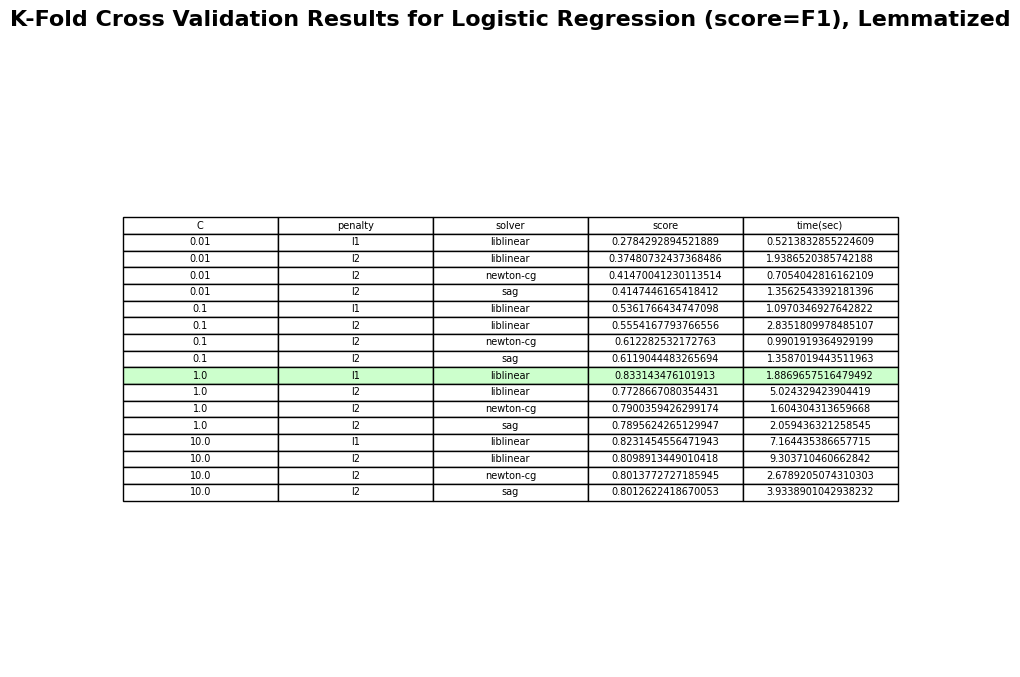

In [79]:
lr_params = {'C': [0.01, 0.1, 1.0, 10.0],
          'penalty': ['l1', 'l2'],
          'solver': ['liblinear', 'newton-cg', 'sag']}

# Here, we use f1-score metric and run cross validation for lemmatized
lr_best_params_lemmatized_f1, lr_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, lr_params, "K-Fold Cross Validation Results for Logistic Regression (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "LogisticRegression")

## Random Forest Classifier

{'params': {'n_estimators': 10, 'max_features': 'log2'}, 'score': 0.6320995148440627, 'time(sec)': 81.71669030189514}
{'params': {'n_estimators': 10, 'max_features': 'sqrt'}, 'score': 0.6887610917563146, 'time(sec)': 71.62657642364502}
{'params': {'n_estimators': 50, 'max_features': 'log2'}, 'score': 0.7128248309027831, 'time(sec)': 404.36925292015076}
{'params': {'n_estimators': 50, 'max_features': 'sqrt'}, 'score': 0.7319178956642187, 'time(sec)': 341.6254868507385}
{'params': {'n_estimators': 100, 'max_features': 'log2'}, 'score': 0.7286194106886079, 'time(sec)': 800.4679760932922}
{'params': {'n_estimators': 100, 'max_features': 'sqrt'}, 'score': 0.739015692869458, 'time(sec)': 699.865549325943}

Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
Best Score: 0.7390



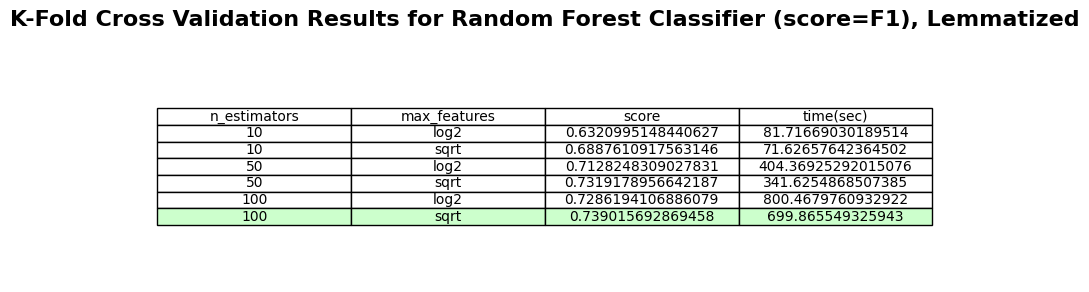

In [80]:
rf_params = {'n_estimators': [10, 50, 100],
             'max_features': ["log2", "sqrt"]}

rf_best_params_lemmatized_f1, rf_best_score_lemmatized_f1 = kfolds_CV(X_train_lemmatized_tfidf, y_train, rf_params, "K-Fold Cross Validation Results for Random Forest Classifier (score=F1), Lemmatized", lambda y_true, y_pred: f1_score(y_true, y_pred, average='macro'), "RandomForestClassifier")

In [81]:
# Train the models on the entire training data

# LR: lemmatized, Best Parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
# Best Score: 0.6217
print("Training Logistic Regression model on all training lemmatized data")
lr_model = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
start_time = time.time()
lr_model.fit(X_train_lemmatized_tfidf, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Finished training {lr_model} model in {training_time:.3f}s.\n")

# RF: lemmatized, Best Parameters: {'n_estimators': 100, 'max_features': 'sqrt'}
# Best Score: 0.5447
print("Training Random Forest Classifier model on all training lemmatized data")
rf_model = RandomForestClassifier(n_estimators=100, max_features='sqrt')
start_time = time.time()
rf_model.fit(X_train_lemmatized_tfidf, y_train)
end_time = time.time()
training_time = end_time - start_time
print(f"Finished training {rf_model} model in {training_time:.3f}s.\n")

Training Logistic Regression model on all training lemmatized data
Finished training LogisticRegression(penalty='l1', solver='liblinear') model in 0.562s.

Training Random Forest Classifier model on all training lemmatized data
Finished training RandomForestClassifier() model in 120.478s.



# Comparative Analysis of the Two Methods on the Dataset

This section covers a detailed comparison between the two machine learning models for the dataset across dimensions including computational complexity, performance, etc., as well as a final recommendation on the method that should go into production for this dataset.

The cell below uses the trained models (using the best set of tunable parameters discovered for each) to get the sentiment predictions on the test data, which recall from before, is already a TF-IDF vectorized version of the processed (cleaned, lemmatized, etc.) version of the original raw text data. This will be used in evaluating and comparing the two models shortly.

In [85]:
y_pred_lr = lr_model.predict(X_test_lemmatized_tfidf)
y_pred_rf = rf_model.predict(X_test_lemmatized_tfidf)

The cell below features utility functions that will be used to help evaluate and compare the two models.

The $\texttt{create\textunderscore confusion\textunderscore matrix}$ function takes in the true sentiment labels and the model's predicted labels and M (the number of classes) and constructs a confusion matrix (non-normalized), where the true labels are rows and predicted labels are columns.

The $\texttt{normalize\textunderscore confusion\textunderscore matrix}$ function takes in a confusion matrix and normalizes it by row (i.e., the true label).

The $\texttt{compute\textunderscore metrics\textunderscore from\textunderscore confusion\textunderscore matrix}$ function uses the passed in confusion matrix to compute the various metrics. It first computes the number of True Positives, False Positives, False Negatives, and True Negatives. It then computes the Precision, Recall, F1 Score, and Support.

The $\texttt{compute\textunderscore macro\textunderscore and\textunderscore weighted\textunderscore averages\textunderscore of\textunderscore metrics}$ function computes the macro (simply average) and weighted (using weights as the support, or number of occurences of the sentiment label) averages of the metrics.

The $\texttt{plot\textunderscore confusion\textunderscore matrix}$ function simply plots a heatmap visualization of the confusion matrix.

The $\texttt{plot\textunderscore classification\textunderscore metrics}$ function plots a side-by-side comparison of the various metrics from both models.

The $\texttt{plot\textunderscore avg\textunderscore metrics}$ function plots a side-by-side comparison of the average metrics (macro and weighted averages) between the two classifiers.

Reference the code and comments for more details and implementation.

In [99]:
def create_confusion_matrix(y_true, y_pred, M):
    """
    Creates an MxM confusion matrix for M classes.
    
    :param y_true: true class labels
    :param y_pred: predicted class labels
    :return: confusion matrix of size MxM
    """
    confusion_mat = np.zeros((M, M), dtype=int) # initialize confusion matrix MxM
    for true, predicted in zip(y_true, y_pred): # true labels as rows, predicted labels as columns
        confusion_mat[true, predicted] += 1
    return confusion_mat

def normalize_confusion_matrix(confusion_mat):
    """
    Normalizes a provided confusion matrix.
    
    :param confusion_mat: confusion matrix to be normalized
    :return: normalized confusion matrix
    """
    # Divide each cell by the total (actual) number of samples with that label (the actuals are stored in rows)
    normalized_confusion_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    return normalized_confusion_mat

def compute_metrics_from_confusion_matrix(confusion_mat):
    """
    Computes metrics (precision, recall, f1 score, support) from confusion matrix.
    
    :param confusion_mat: the confusion matrix
    :return: the computed metrics
    """
    # M classes
    M = confusion_mat.shape[0]
    metrics = []
    
    # Loop through each class
    for j in range(M):
        TP = confusion_mat[j,j] # TP = number of positive labels correctly predicted
        FP = confusion_mat[:,j].sum() - TP # FP = number of negative labels incorrectly predicted as positive
        FN = confusion_mat[j,:].sum() - TP # FN = number of positive labels incorrectly predicted as negative
        TN = confusion_mat.sum() - (TP + FP + FN) # TN = number of negative labels correctly predicted
        
        if (TP + FP) > 0: # avoid divide by 0
            precision = TP / (TP + FP)
        else:
            precision = 0.0
            
        if (TP + FN) > 0: # avoid divide by 0
            recall = TP / (TP + FN)
        else:
            recall = 0.0
        
        if ((1 / precision) + (1 / recall)) > 0: # avoid divide by 0
            f1_score = 2 / ((1 / precision) + (1 / recall))
        else:
            f1_score = 0.0
            
        support = confusion_mat[j,:].sum() # support = number of actual occurences of the class in the dataset
        
        metrics.append({'precision': precision, 'recall': recall, 'f1_score': f1_score, 'support': support})
    return metrics

def compute_macro_and_weighted_averages_of_metrics(metrics):
    """
    Computes the macro and weighted averages of the passed in metrics.
    
    :param metrics: the metrics (precision, recall, f1_score, support)
    :return: the macro and weighted averages of the metrics
    """    
    # M classes
    M = len(metrics)
    
    # Compute the weighted metric averages
    weighted_avg_precision = np.average([metric['precision'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_recall = np.average([metric['recall'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    weighted_avg_f1 = np.average([metric['f1_score'] for metric in metrics], weights=[metric['support'] for metric in metrics])
    
    # Compute the macro metric averages
    macro_avg_precision = np.mean([metric['precision'] for metric in metrics])
    macro_avg_recall = np.mean([metric['recall'] for metric in metrics])
    macro_avg_f1 = np.mean([metric['f1_score'] for metric in metrics])
    
    return {
        'weighted_avg_precision': weighted_avg_precision,
        'weighted_avg_recall': weighted_avg_recall,
        'weighted_avg_f1': weighted_avg_f1,
        'macro_avg_precision': macro_avg_precision,
        'macro_avg_recall': macro_avg_recall,
        'macro_avg_f1': macro_avg_f1
    }
    
def plot_confusion_matrix(confusion_mat, classes, title, normalized=False):
    """
    Plots a heatmap version of confusion matrix for visual analysis.
    
    :param confusion_mat: the confusion matrix
    :param classes: the name of the classes
    :param title: title for the plot
    :param normalized: whether or not the matrix is normalized
    """
    plt.figure(figsize=(8,6))
    if not normalized:
        sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    else:
        sns.heatmap(confusion_mat, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
def plot_classification_metrics(metrics_classifier1, metrics_classifier2, models, classes, title):
    """
    Plots a comparison of the various metrics between two classifiers.
    
    :param metrics_classifier1: metrics of the first classifier
    :param metrics_classifier2: metrics of the second classifier
    :param models: names of the models
    :param title: the title of the plot
    :param classes: names of the classes
    """    
    # Convert the metrics to Dataframes
    df_classifier1 = pd.DataFrame(metrics_classifier1, index=classes)
    df_classifier2 = pd.DataFrame(metrics_classifier2, index=classes)
    
    # Concatenate the metrics from both classifiers together to allow comparisons
    combined_metrics = pd.concat([df_classifier1, df_classifier2], keys=models, axis=1)
        
    # Display a heatmap of the metrics side by side
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(combined_metrics.iloc[:,:], annot=True, fmt=".2f", cmap="YlGnBu", cbar=True, ax=ax)
    plt.title(title)
    plt.xlabel('Metrics')
    plt.ylabel('Sentiment')
    plt.show()
    
def plot_avg_metrics(avg_metrics_classifier1, avg_metrics_classifier2, name_classifier1, name_classifier2):
    """
    Plots the macro and weighted averages of the metrics of two classifiers.
    
    :param avg_metrics_classifier1: average metrics for the first classifier
    :param avg_metrics_classifier2: average metrics for the second classifier
    :param name_classifier1: name of the first classifier
    :param name_classifier2: name of the second classifier
    """
    # Get the name and values of the metrics for each classifier
    metrics = list(avg_metrics_classifier1.keys())
    classifier1_metrics = list(avg_metrics_classifier1.values())
    classifier2_metrics = list(avg_metrics_classifier2.values())
    
    # Bar positions
    x = np.arange(len(metrics))
    width = 0.35 # width of each bar
    
    # Plot the side by side average metrics between the two classifiers
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, classifier1_metrics, width, label=name_classifier1, color='skyblue')
    ax.bar(x + width / 2, classifier2_metrics, width, label=name_classifier2, color='salmon')
    
    # Labels, title, etc.
    ax.set_xticks(x)
    ax.set_xticklabels(metrics, rotation=45, ha='right')
    ax.set_xlabel('Metric')
    ax.set_ylabel('Metric Value')
    ax.set_title('Comparison of Average Metrics between Logistic Regression and Random Forest Classifier')
    ax.legend()
    
    # Show plot
    plt.tight_layout()
    plt.show()

In [104]:
print("LOGISTIC REGRESSION:")
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("RANDOM FOREST CLASSIFIER:")
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

LOGISTIC REGRESSION:
[[1345  100  188]
 [  56  502   61]
 [ 135   52 1359]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1633
           1       0.77      0.81      0.79       619
           2       0.85      0.88      0.86      1546

    accuracy                           0.84      3798
   macro avg       0.83      0.84      0.83      3798
weighted avg       0.85      0.84      0.84      3798

RANDOM FOREST CLASSIFIER:
[[1147  132  354]
 [ 119  375  125]
 [ 236   74 1236]]
              precision    recall  f1-score   support

           0       0.76      0.70      0.73      1633
           1       0.65      0.61      0.62       619
           2       0.72      0.80      0.76      1546

    accuracy                           0.73      3798
   macro avg       0.71      0.70      0.70      3798
weighted avg       0.73      0.73      0.73      3798



Now that the utility functions above are defined, it is time to begin evaluating the two models. First, there will be a comparison of their confusion matrices, which can help visualize and provide insight into the *types* of misclassifications (or correct classifications) being made by both models.

3


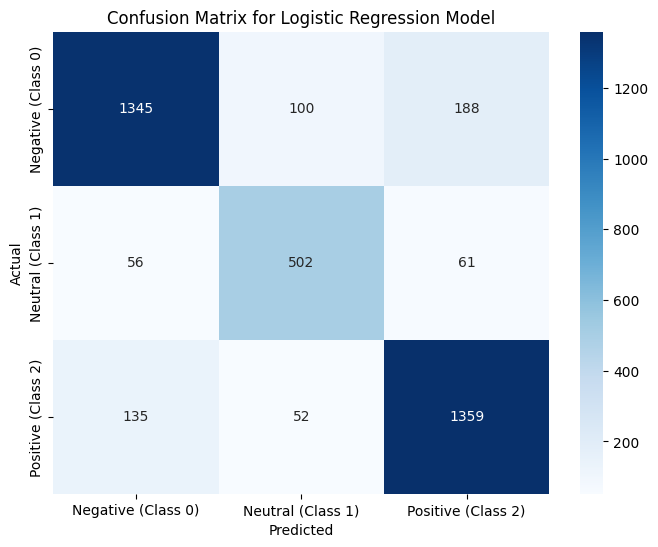

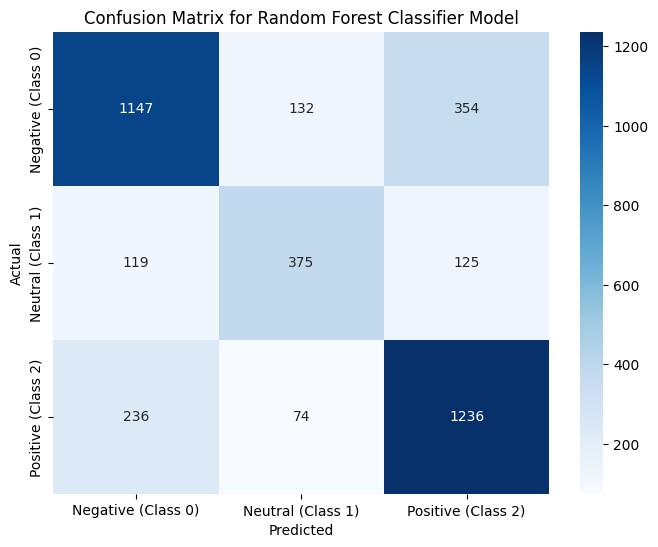

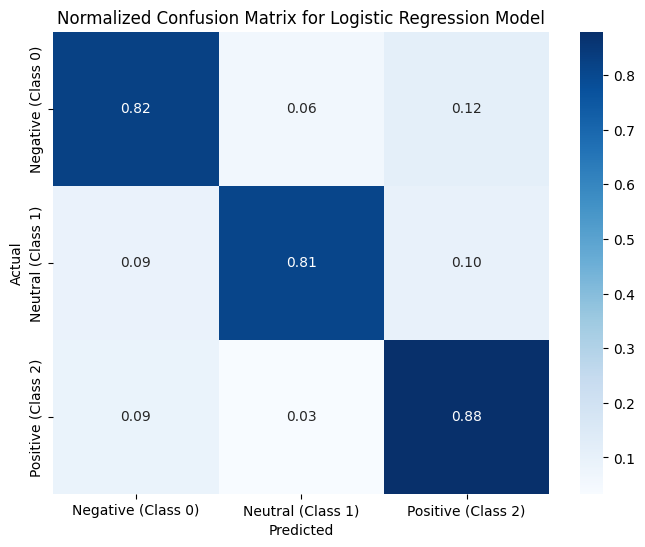

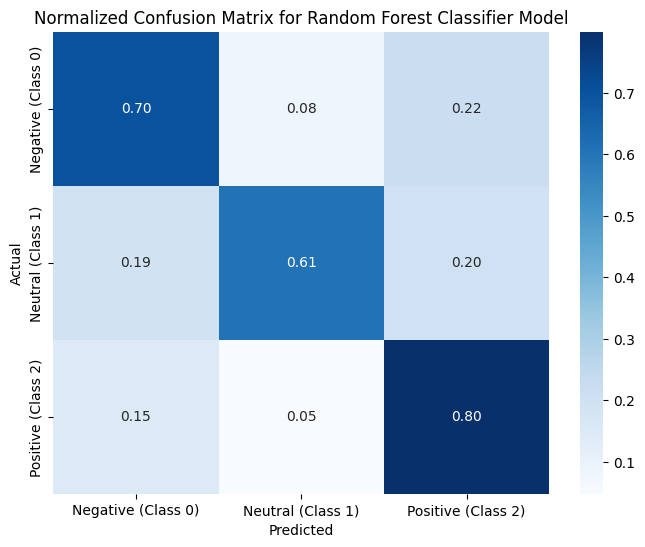

In [100]:
# Number of classes
M = len(np.unique(y_test))
print(M)

# Compute confusion matrices for both classifiers
confusion_mat_lr = create_confusion_matrix(y_test, y_pred_lr, M)
confusion_mat_rf = create_confusion_matrix(y_test, y_pred_rf, M)

# Map the encoded labels back to the sentiment for easier analysis
map_labels_to_sentiment = {
    0: 'Negative (Class 0)',
    1: 'Neutral (Class 1)',
    2: 'Positive (Class 2)',
}

# Plot the confusion matrix for both classifiers
classes = [map_labels_to_sentiment[i] for i in range(M)]
plot_confusion_matrix(confusion_mat_lr, classes, "Confusion Matrix for Logistic Regression Model", normalized=False)
plot_confusion_matrix(confusion_mat_rf, classes, "Confusion Matrix for Random Forest Classifier Model", normalized=False)

# Plot the normalized confusion matrices for both classifiers
normalized_confusion_mat_lr = normalize_confusion_matrix(confusion_mat_lr)
normalized_confusion_mat_rf = normalize_confusion_matrix(confusion_mat_rf)
plot_confusion_matrix(normalized_confusion_mat_lr, classes, "Normalized Confusion Matrix for Logistic Regression Model", normalized=True)
plot_confusion_matrix(normalized_confusion_mat_rf, classes, "Normalized Confusion Matrix for Random Forest Classifier Model", normalized=True)

First, observe the confusion matrix for the Logistic Regression model. It is more convenient to focus on the normalized version as it describes the rates of misclassifications and makes it easier to compare. 

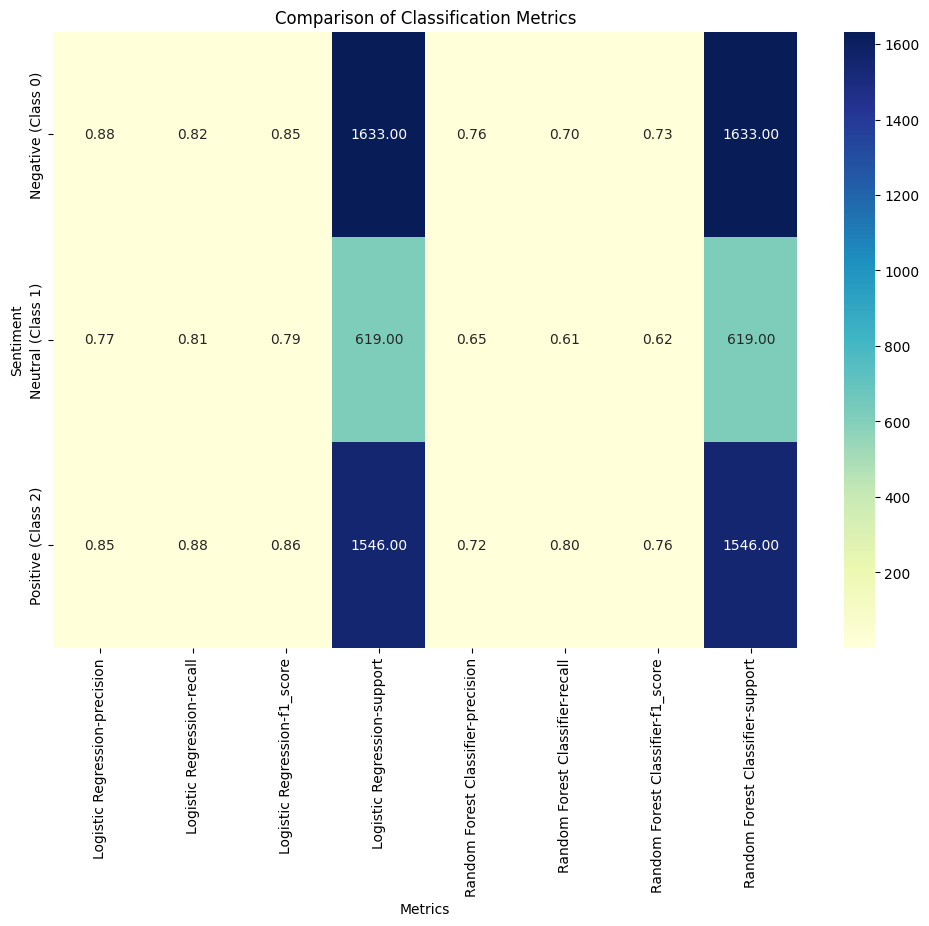

In [89]:
# Compute metrics for both classifiers
metrics_lr = compute_metrics_from_confusion_matrix(confusion_mat_lr)
metrics_rf = compute_metrics_from_confusion_matrix(confusion_mat_rf)

# Plot the comparisons of metrics of the classifiers
plot_classification_metrics(metrics_lr, metrics_rf, ["Logistic Regression", "Random Forest Classifier"], classes, "Comparison of Classification Metrics")

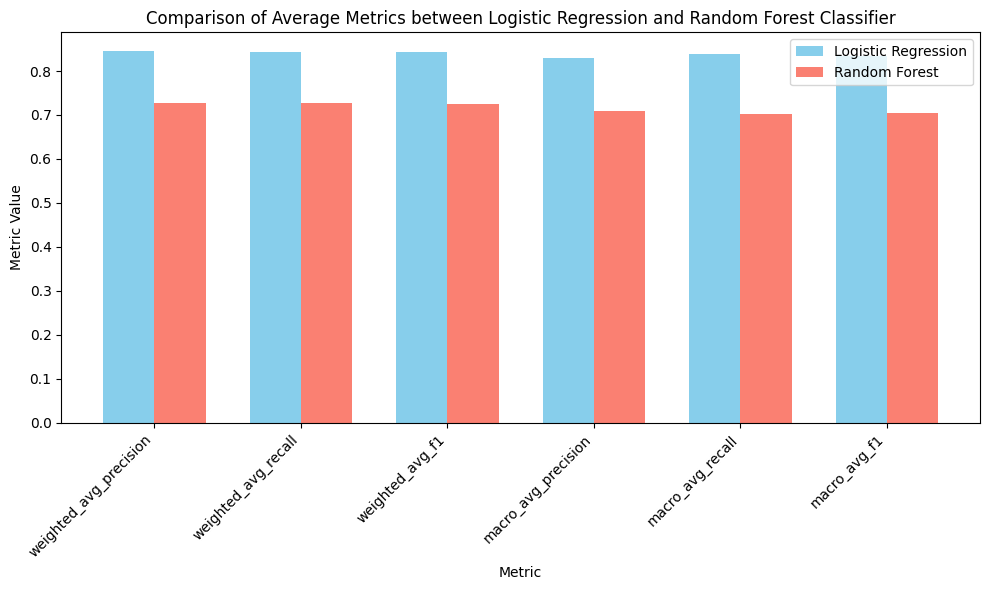

In [88]:
# Compute the macro and weighted averages of the metrics for both classifiers
avg_metrics_lr = compute_macro_and_weighted_averages_of_metrics(metrics_lr)
avg_metrics_rf = compute_macro_and_weighted_averages_of_metrics(metrics_rf)

# Plot comparisons of the average metrics between the classifiers
plot_avg_metrics(avg_metrics_lr, avg_metrics_rf, "Logistic Regression", "Random Forest")

# Discussion on Ethical Issues for the Dataset/Task

This section provides a discussion on the ethical aspects of the machine learning task carried out on this dataset.

ETHICS!

# Bibliography

bib